## Beer Data Analysis
### By: Kshitij Raj

### Table of Contents:
- 1. Import dataset.
- 2. EDA.
- 3. Derived Metrics
- 4. Text Preprocessing
- 5. Data Visualization
- 6. Questions and Solution

In [1]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#unzip dataset
!unzip -q "/content/drive/MyDrive/BeerDataScienceProject.zip"

replace BeerDataScienceProject.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [3]:
#Install swifter
# Swifter -A package which efficiently applies any function to a pandas dataframe or series in the fastest available manner.
# https://pypi.org/project/swifter/#description
!pip install swifter

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import swifter

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
#Read the dataset.
data = pd.read_csv("/content/BeerDataScienceProject.csv",encoding = "unicode_escape", low_memory=False)
data.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [6]:
#Shape of the dataframe
data.shape

(528870, 13)

In [7]:
beer_data = data.copy()

## EDA

In [8]:
#Data Type and null value count of variables present in the dataset. 
beer_data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            508590 non-null  float64
 1   beer_beerId         528870 non-null  int64  
 2   beer_brewerId       528870 non-null  int64  
 3   beer_name           528870 non-null  object 
 4   beer_style          528870 non-null  object 
 5   review_appearance   528870 non-null  float64
 6   review_palette      528870 non-null  float64
 7   review_overall      528870 non-null  float64
 8   review_taste        528870 non-null  float64
 9   review_profileName  528755 non-null  object 
 10  review_aroma        528870 non-null  float64
 11  review_text         528751 non-null  object 
 12  review_time         528870 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 52.5+ MB


In [9]:
#Unique value present in the every varaibles
beer_data.nunique()

beer_ABV                 283
beer_beerId            20200
beer_brewerId           1803
beer_name              18339
beer_style               104
review_appearance         10
review_palette             9
review_overall            10
review_taste               9
review_profileName     22800
review_aroma               9
review_text           528371
review_time           527927
dtype: int64

##### Observation:
- There are 20200 unique Beer ID but only 18339 unique Beer name might be there are some beer which has same name but different Bear ID.

In [10]:
#Verify the above observation

count = {}
for i in range(beer_data.shape[0]):
    if beer_data['beer_name'][i] in count:
        if beer_data['beer_beerId'][i] not in count[(beer_data['beer_name'][i])]:
            count[beer_data['beer_name'][i]].append((beer_data['beer_beerId'][i]))
    else:
        count[beer_data['beer_name'][i]] =[(beer_data['beer_beerId'][i])]

beer_name = []
for i in list(count.keys()):
    if len(count[i]) > 1:
        beer_name.append([i,"".join(str(count[i]))])
        
print("Number of beer which has more than one beer ID -> "+str(len(beer_name)))
#List of beer name which has more than one beer ID. Format(['beer name','bear IDs'])
beer_name

Number of beer which has more than one beer ID -> 619


[['Coconut Porter', '[76963, 65755]'],
 ['Imperial Stout',
  '[42964, 76846, 57469, 15364, 10368, 35184, 40252, 790, 29674, 41013, 18717, 36105, 41554, 66792, 64229, 36932, 356]'],
 ['Celebration Ale', '[45855, 27703, 41417, 40532]'],
 ["Luck O' The Irish", '[68668, 44880]'],
 ['City Pale Ale', '[30088, 3470]'],
 ['Original Lager', '[23329, 76417, 12542, 19985]'],
 ['Holiday Ale', '[27666, 15468, 2210, 46391, 48032]'],
 ['Pumpkin Ale',
  '[26817, 33272, 13350, 72875, 6730, 15220, 45907, 26666, 14399, 33509, 46316, 14372, 56646, 53381, 13881, 54711, 13676, 52615, 53807, 39098, 33586, 53819, 40701, 62731, 2980, 6999, 54200]'],
 ['Dry Stout', '[26133, 17499, 23362, 29661, 68338, 67077]'],
 ['Wheat Ale', '[26418, 21788, 69944, 71681]'],
 ['Pale Ale',
  '[26420, 32733, 65210, 13009, 25656, 1952, 28951, 69515, 25748, 59802, 24997, 22685, 56361, 18178, 29612, 28768, 30268, 43116, 5939, 55960, 39026, 21508, 69647, 37938, 38644, 1983, 54878, 23046, 5095, 76346, 7756, 39645, 35007, 476, 2720, 25

In [11]:
#Check data for beer having more than 1 beer ID.
beer_data[beer_data['beer_name']=='Coconut Porter']

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
711,9.5,76963,1075,Coconut Porter,American Porter,4.0,4.0,4.0,3.5,Rifugium,4.0,"First had: on tap at Concordia Ale House, Port...",1325439672
358450,NaN,65755,7527,Coconut Porter,American Porter,3.5,3.5,3.5,4.0,timtwoface,4.0,I had this delicious beer numerous times a yea...,1321778736
358451,NaN,65755,7527,Coconut Porter,American Porter,4.0,3.5,4.0,3.5,BDTyre,3.5,I was surprised to see this as I thought it wa...,1296410450


##### Inference:
- From above table it is clear that different Brewer made the beer with same name but different beer ID

In [12]:
#Null value percentage of columns
round(beer_data.isnull().sum()/beer_data.shape[0]*100,3)

beer_ABV              3.835
beer_beerId           0.000
beer_brewerId         0.000
beer_name             0.000
beer_style            0.000
review_appearance     0.000
review_palette        0.000
review_overall        0.000
review_taste          0.000
review_profileName    0.022
review_aroma          0.000
review_text           0.023
review_time           0.000
dtype: float64

In [13]:
#Remove rows for which review_text is NaN.
beer_data = beer_data[~(beer_data['review_text'].isnull())]

In [14]:
#Remove rows for which review_profilename is NaN.
beer_data = beer_data[~(beer_data['review_profileName'].isnull())]

#### Sanity Checks

In [15]:
#Check whether there is duplicate row present in the dataset.
beer_data[beer_data.duplicated()]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time


In [16]:
#Check whether any beer ABV is less than 0.
beer_data[beer_data['beer_ABV'] < 0]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time


In [17]:
#Check wether any review is in negative.
beer_data[(beer_data['review_appearance'] < 0) | (beer_data['review_palette'] < 0) | (beer_data['review_overall'] < 0) |
          (beer_data['review_taste'] < 0)      | (beer_data['review_aroma'] < 0)]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time


In [18]:
#Check whether there is any duplicate review present in the dataset
beer_data[beer_data.duplicated(subset=['review_text'], keep=False)]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
2197,10.9,61864,14756,Mephistopheles' Metamorphosis,Tripel,4.0,4.0,3.5,4.0,scoobybrew,3.5,A - hazy (perhaps slightly from bottle conditi...,1284516843
7138,5.5,62829,12003,Robust Porter,American Porter,4.0,3.5,4.0,4.0,Brunite,4.0,"A: The deepest, darkest brown with a fringe of...",1304028957
7261,6.4,56259,22167,Sweet Child Of Vine,English India Pale Ale (IPA),3.5,3.5,3.5,3.5,iLovehops23,3.0,A: Very cloudy with about 1.5 finger width of ...,1321233080
7285,6.4,56259,22167,Sweet Child Of Vine,English India Pale Ale (IPA),3.5,3.5,4.0,4.0,sonata2008,4.5,A: Very cloudy with about 1.5 finger width of ...,1280976800
7849,5.0,27597,765,Elora Irish Ale,Irish Red Ale,2.5,2.5,3.0,2.5,pootz,3.0,650 ML bomber. A hard pour revealed a clear co...,1135986352
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522179,5.0,575,113,Samuel Smith's Old Brewery Pale Ale,English Pale Ale,3.0,3.5,4.0,4.0,thechamp,3.5,Pours a clear deep copper with dense head. Sme...,1216152749
522488,5.0,575,113,Samuel Smith's Old Brewery Pale Ale,English Pale Ale,4.0,3.5,4.0,4.5,moki,4.0,Pours a clear deep copper with dense head. Sme...,1088740843
522702,5.2,47486,113,Samuel Smith's Organic Strawberry Fruit Beer,Fruit / Vegetable Beer,5.0,5.0,5.0,5.0,Nuixx,5.0,I was mildly skeptical of this ale's fruity pr...,1298767349
522731,5.2,47486,113,Samuel Smith's Organic Strawberry Fruit Beer,Fruit / Vegetable Beer,4.0,4.0,4.5,4.0,bonbright7,5.0,I was mildly skeptical of this ale's fruity pr...,1274231918


#### Observation: 
- There are 651 rows in which review_text is duplicated.
- But some reviews which are duplicate is from different reviewer and review date is also different
- For Example for row 522731 and 522702 have the same review text but one review is from year2011 and other is from 2010 and by different reviewer.
- There are some reviews for which text is #NAME? 526180	

In [19]:
#Remove rows for which review_tet is #NAME?
beer_data = beer_data[~(beer_data['review_text']=="#NAME?")]

In [20]:
#Further Analysis on duplicate review_text
beer_data['review_text'].value_counts().head(5)

Pours a light yellow color, nice carbonation, small white head, with some sticky lacing left behind. The nose is malty, with some hops, slight caramel. The taste is slightly sweet, malty, slight hop note. Light body. Not drinkable, would not buy again.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [21]:
example_review= "Pours a light yellow color, nice carbonation, small white head, with some sticky lacing left behind. The nose is malty, with some hops, slight caramel. The taste is slightly sweet, malty, slight hop note. Light body. Not drinkable, would not buy again."
beer_data[beer_data['review_text']== example_review]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
172185,4.70,689,221,Red Stripe Jamaican Lager,American Adjunct Lager,2.5,2.5,2.5,2.5,Wasatch,2.5,"Pours a light yellow color, nice carbonation, ...",1268579160
323065,4.78,3906,447,Olympia Beer,American Adjunct Lager,1.5,1.5,1.5,1.5,Wasatch,1.5,"Pours a light yellow color, nice carbonation, ...",1268701605
324168,4.74,1331,447,Pabst Blue Ribbon (PBR),American Adjunct Lager,3.0,2.5,2.5,2.5,Wasatch,2.5,"Pours a light yellow color, nice carbonation, ...",1268445945
325384,4.60,1332,447,Old Milwaukee Beer,American Adjunct Lager,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268701503
326179,5.61,1334,447,Colt 45 Malt Liquor,American Malt Liquor,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268701121
326354,4.60,1330,447,Stroh's,American Adjunct Lager,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268701925
326589,4.72,1719,447,Lone Star Beer,American Adjunct Lager,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268701405
349281,4.20,837,306,Coors Light,Light Lager,2.0,1.5,1.5,1.5,Wasatch,1.5,"Pours a light yellow color, nice carbonation, ...",1268521518
351049,5.90,2947,306,Keystone Ice,American Adjunct Lager,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268699646
351305,5.00,1276,306,Coors,American Adjunct Lager,2.0,2.0,2.0,2.0,Wasatch,2.0,"Pours a light yellow color, nice carbonation, ...",1268510254


In [22]:
example_review2 = "I really do not care for this beer or any molson beer, it gives me really bad gas. Light color and body with no hops or malt just a bunch of corn and rice. My mother in law comes and she brings the crap, so i have to drink it and my wife puts up with the gas."
beer_data[beer_data['review_text']== example_review2]

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
363033,5.0,1312,433,Molson Canadian Lager,American Adjunct Lager,2.5,2.5,3.0,2.5,kunzbrew,2.5,I really do not care for this beer or any mols...,1033072257
363636,4.0,5583,433,Molson Canadian Light,Light Lager,2.5,2.0,3.0,2.5,kunzbrew,2.5,I really do not care for this beer or any mols...,1033072357
364253,5.0,1837,433,Molson Export,American Blonde Ale,2.5,2.0,2.5,2.0,kunzbrew,2.5,I really do not care for this beer or any mols...,1033072465


#### Observation:
- In the above code we can see that there are 10 reviews which has a same text and from the same person but for different beer name and the rating is also different.

** Not sure what to do with this data so keeping as it is.

## Derived Metrics

In [23]:
#Function to convert 10 digit epoch to timestamp
def convert_to_time(time):
    dt = datetime.datetime.fromtimestamp(time)
    dt = dt.strftime('%Y-%m-%d::%H-%M')
    return dt

beer_data['review_time'] = beer_data['review_time'].apply(convert_to_time)

beer_data['review_time']

0         2009-02-16::20-57
1         2009-03-01::13-44
2         2009-03-01::14-10
3         2009-02-15::19-12
4         2010-12-30::18-53
                ...        
528865    2008-03-11::05-18
528866    2008-02-20::06-59
528867    2008-01-26::04-14
528868    2008-01-24::22-54
528869    2008-01-14::18-46
Name: review_time, Length: 528544, dtype: object

In [24]:
#Create review_year which stores year on which review is given.
beer_data['review_year'] = pd.to_datetime(beer_data['review_time'],format="%Y-%m-%d::%H-%M").dt.year

## Text Preprocessing

In [25]:
#Text Preprocessing
""" VADER Sentiment Analysis :
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.
VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative.
VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.
"https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/"
"""

sid = SentimentIntensityAnalyzer()

def textpreprocess(review):
  scores = sid.polarity_scores(review)
  compound_score =  scores['compound']
  review_type = 'Positive' if compound_score >=0 else 'Negative'
  return review_type

beer_data['review_text_type'] =beer_data['review_text'].swifter.apply(textpreprocess)

Pandas Apply:   0%|          | 0/528544 [00:00<?, ?it/s]

In [26]:
#stopwordsin english language
stop_words = set(stopwords.words('english'))
#Add beer also in the stopwords chances are lot of reviews contains beer word
stop_words.add('beer')
#Word lemmatizer
lemma = WordNetLemmatizer()


# Function to clean the reviews.
def cleantext(review_text):
  review_text = re.sub('[^a-zA-Z]',' ',review_text)                     # Remove number and punctuation
  review_text = str(review_text).lower()                                # Lower the text
  review_text = word_tokenize(review_text)                              # Tokenize word
  review_text = [item for item in review_text if item not in stop_words]# Remove stopwords from the sentence
  review_text = [lemma.lemmatize(word=w,pos='v') for w in review_text]  # Lemmatize the word
  review_text = [i for i in review_text if len(i) > 1]                  # Remove single character from the sentence
  review_text = " ".join(review_text)
  return review_text

beer_data['clean_review_text'] = beer_data['review_text'].swifter.apply(cleantext)

Pandas Apply:   0%|          | 0/528544 [00:00<?, ?it/s]

In [27]:
#Print 10 rows after text preprocessing.
beer_data.head(10)

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,review_year,review_text_type,clean_review_text
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,2009-02-16::20-57,2009,Positive,lot foam lot smell banana lactic tart good sta...
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",2009-03-01::13-44,2009,Positive,dark red color light beige foam average smell ...
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",2009-03-01::14-10,2009,Positive,almost totally black beige foam quite compact ...
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",2009-02-15::19-12,2009,Positive,golden yellow color white compact foam quite c...
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",2010-12-30::18-53,2010,Positive,accord website style caldera cauldron change e...
5,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.5,3.0,3.0,oline73,3.5,Poured from the bottle into a Chimay goblet. A...,2012-01-02::17-17,2012,Positive,pour bottle chimay goblet appearance pour slig...
6,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.5,3.5,4.0,Reidrover,4.0,"22 oz bottle from ""Lifesource"" Salem. $3.95 Ni...",2011-10-19::02-25,2011,Positive,oz bottle lifesource salem nice golden clear b...
7,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,2.5,3.0,2.0,alpinebryant,3.5,"Bottle says ""Malt beverage brewed with Ginger ...",2011-05-24::22-26,2011,Positive,bottle say malt beverage brew ginger ginger ad...
8,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,3.5,3.0,4.0,3.5,LordAdmNelson,4.0,I'm not sure why I picked this up... I like gi...,2010-11-22::19-35,2010,Positive,sure pick like ginger reasonably cheap compare...
9,4.7,52159,1075,Caldera Ginger Beer,Herbed / Spiced Beer,5.0,3.5,4.5,4.0,augustgarage,4.0,Poured from a 22oz bomber into my Drie Fontein...,2010-09-28::00-15,2010,Positive,pour oz bomber drie fonteinen tumbler hazy tit...


## Data Visualization

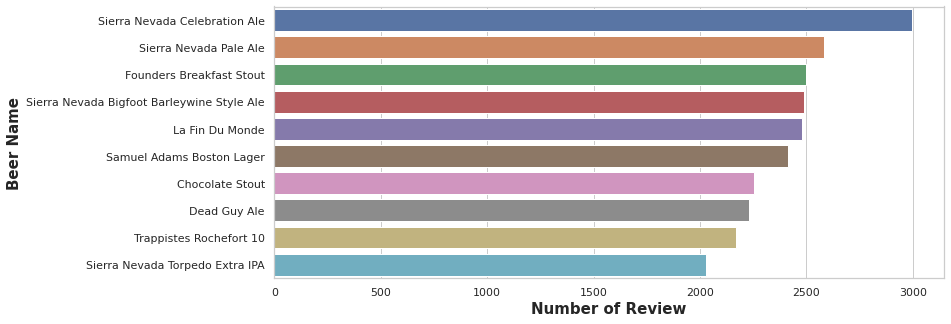

In [28]:
#Top 10 beer which has highest review count.
top10_beername = pd.DataFrame(beer_data.groupby('beer_name')['review_text'].count().sort_values(ascending=False).head(10))
top10_beername = top10_beername.reset_index()
plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")
ax=sns.barplot(x='review_text',y='beer_name', data=top10_beername)
plt.xlabel('Number of Review',fontsize = 15,fontweight ='bold')
plt.ylabel('Beer Name',fontsize = 15,fontweight ='bold')
plt.show()

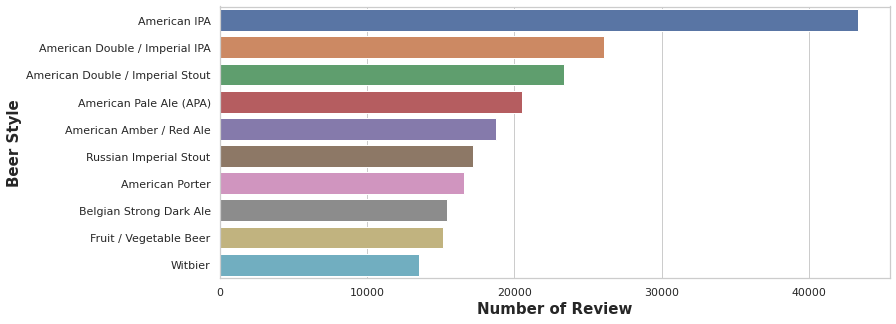

In [29]:
#Top 10 beer style which has highest review count.
top10_beerstyle = pd.DataFrame(beer_data.groupby('beer_style')['review_text'].count().sort_values(ascending=False).head(10))
top10_beerstyle = top10_beerstyle.reset_index()
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='review_text',y='beer_style', data=top10_beerstyle)
plt.xlabel('Number of Review',fontsize = 15,fontweight ='bold')
plt.ylabel('Beer Style',fontsize = 15,fontweight ='bold')
plt.show()


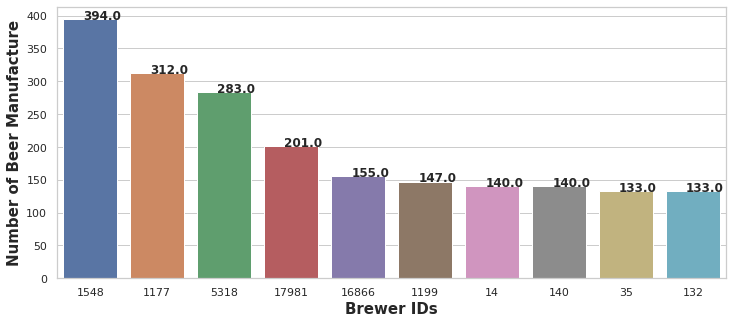

In [30]:
#Top 10 Brewer that manfacutre most number of different beers (by beer name)
top10_brewer = beer_data.groupby('beer_brewerId')['beer_name'].nunique().sort_values(ascending=False).head(10)
top10_brewer = top10_brewer.reset_index()
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='beer_brewerId',y='beer_name', data=top10_brewer,order=top10_brewer['beer_brewerId'])
plt.xlabel('Brewer IDs',fontsize = 15,fontweight ='bold')
plt.ylabel('Number of Beer Manufacture',fontsize = 15,fontweight ='bold')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()),fontweight ='bold')
plt.show()

##### Observation:
- Brewer - 1548 make 394 different beers

In [31]:
# Name of the beer made by the Brewer(1548)
list(beer_data[beer_data['beer_brewerId']==1548]['beer_name'].unique())

['Pacific Coast IPA',
 'Northern Lights Honey Spice',
 'Oatmeal Amber',
 "John Harvard's Light",
 'A Doppelbock Named Sue',
 'Rye Weiss',
 'Potomac Porter',
 'Shakespeare\'s "Plonk"',
 'Mid-Winter Ale',
 'The Softest Bullet Ever Shot',
 'Blackberry Blonde',
 'Holy SIP',
 'Arch Angel',
 'Red Devil',
 'Apeman Ale',
 'West Side Wheat',
 'California Stars',
 'Double O Stout',
 'Holiday Winterfest',
 'Imperial Stout',
 'Shoreditch',
 'Wit',
 'Ace Of Spades Double Stout',
 'Fire Engine Red',
 'Chewbacca IPA',
 'Maibock',
 'Nut Brown Ale',
 'British Pale Mild',
 'Moving Pictures IPA',
 'Presidential Weizenbock',
 'Cold As Helles Lager',
 'Dubbel Time Ale',
 'Baltic Porter',
 'Pure Pilsen',
 'Brown Recluse IPA',
 'Farmhouse Ale',
 'Oktoberfest',
 'Fat Turkey Brown',
 'Farewell Summer Saison',
 'G.P.S. IPA',
 'Belgian Spiced Ale',
 'Export Stout',
 'Espresso Stout',
 'Irish Red Ale',
 'Robust Porter',
 'Sour Puss',
 'Old Eagle Wheat Wine',
 'Sucker-Punch IPA',
 'Wildberry Lager',
 'Czechmate Al

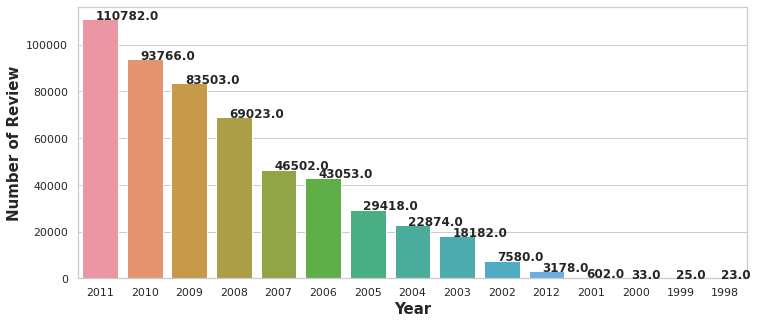

In [32]:
#Number of reviews by year
year_review = pd.DataFrame(beer_data.groupby('review_year')['review_text'].count().sort_values(ascending=False))
year_review = year_review.reset_index()
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='review_year',y='review_text', data=year_review,order=year_review['review_year'])
plt.xlabel('Year',fontsize = 15,fontweight ='bold')
plt.ylabel('Number of Review',fontsize = 15,fontweight ='bold')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()),fontweight ='bold')
plt.show()

##### Observation:
- 2012 have only 3289 number of reviews.

In [33]:
# Verify the above observation.
pd.to_datetime(beer_data[beer_data['review_year'] == 2012]['review_time'],format="%Y-%m-%d::%H-%M").dt.month.unique()

array([1])

##### Inference:
- As 2012 have only one month of review thats the reason number of tweets are less

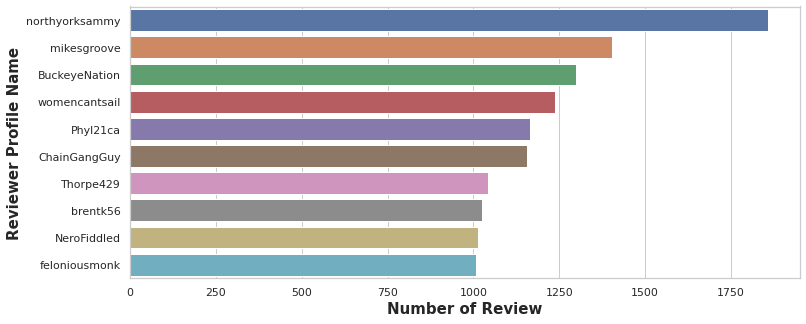

In [34]:
#Top 10 reviewer who have given most review.
top10_reviewer = pd.DataFrame(beer_data.groupby('review_profileName')['review_text'].count().sort_values(ascending=False).head(10))
top10_reviewer = top10_reviewer.reset_index()
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='review_text',y='review_profileName', data=top10_reviewer)
plt.xlabel('Number of Review',fontsize = 15,fontweight ='bold')
plt.ylabel('Reviewer Profile Name',fontsize = 15,fontweight ='bold')
plt.show()

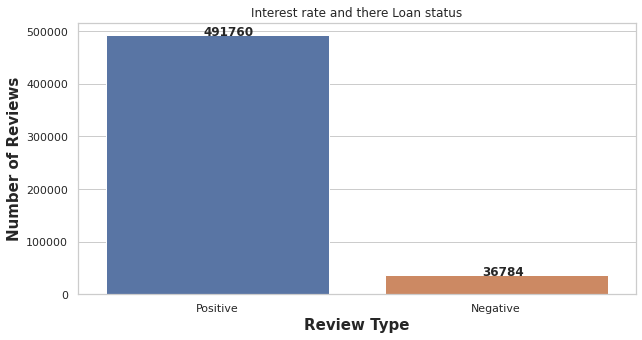

In [35]:
#Number of Positive and Negative review in the dataset.
plt.figure(figsize=(10,5))
ax=sns.countplot(x=beer_data['review_text_type'])
plt.xlabel('Review Type',fontweight ='bold',fontsize = 15)
plt.ylabel('Number of Reviews',fontweight ='bold',fontsize = 15)
plt.title('Interest rate and there Loan status')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.35, p.get_height()),fontweight ='bold')

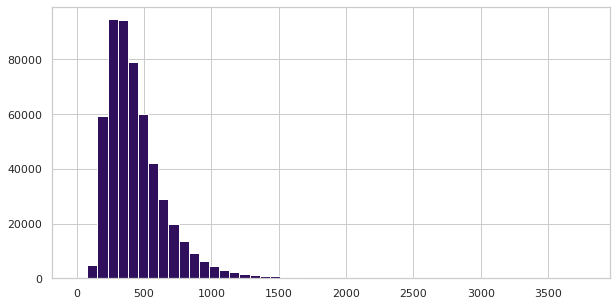

In [36]:
# Plot a hist of the word counts for the clean reviews
fig = plt.figure(figsize=(10,5))

plt.hist(beer_data['clean_review_text'].str.len(), bins=50, color='#30105C')
plt.show()


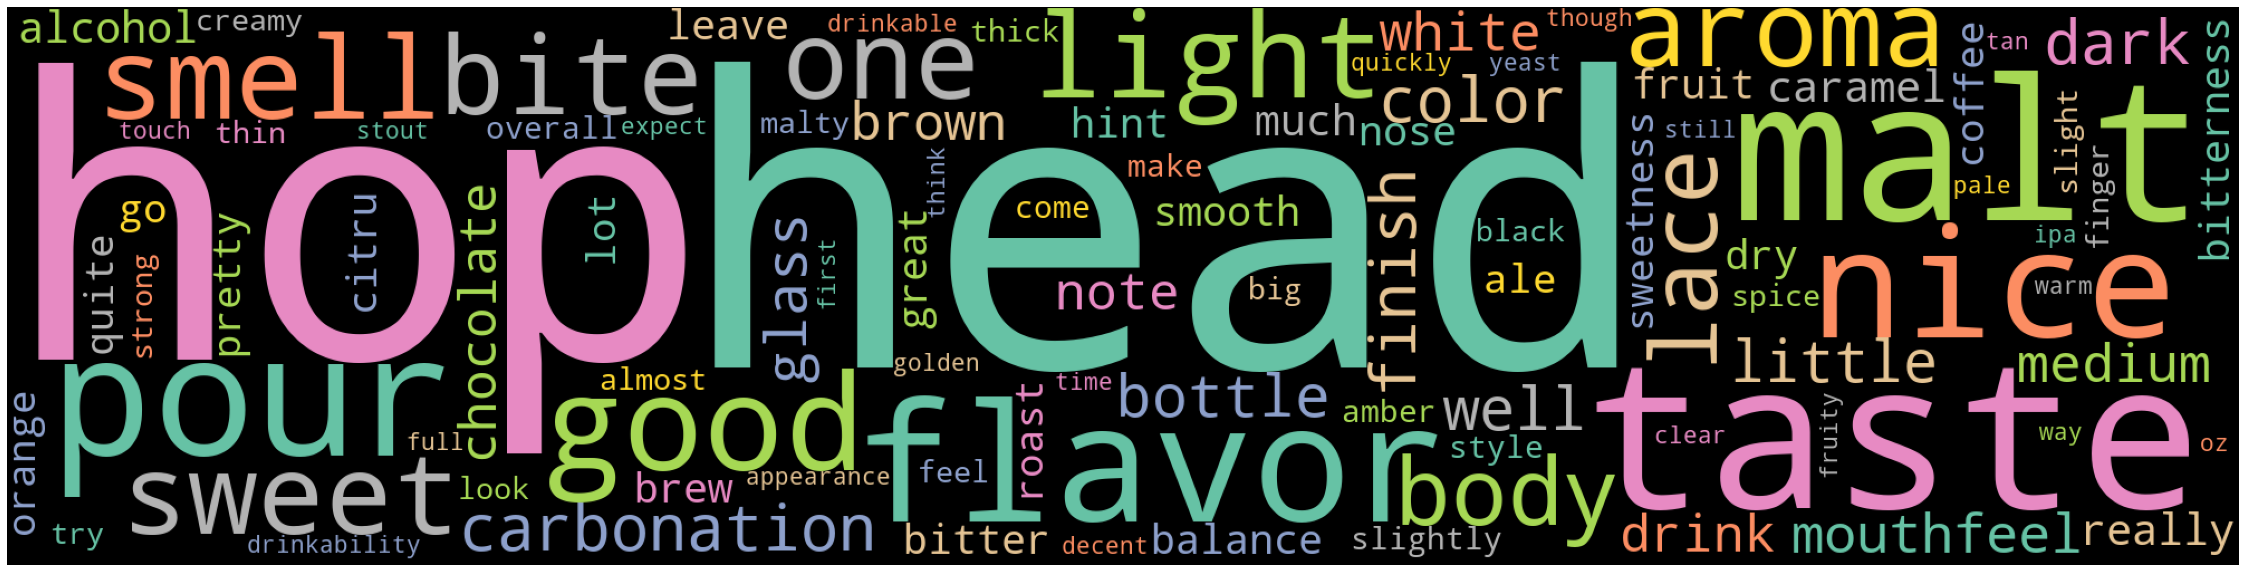

In [37]:
#Top 100 word by frequency present in the cleaned review text
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

freqwords = " ".join(beer_data['clean_review_text'])

# Generate wordcloud
wordcloud = WordCloud(width = 2000, height = 500, random_state=1, background_color='black', colormap='Set2', collocations=False,max_words=100,stopwords = STOPWORDS).generate(freqwords)
# Plot
plot_cloud(wordcloud)

### Questions and Solution

##### Question: Rank top 3 Breweries which produce the strongest beers?

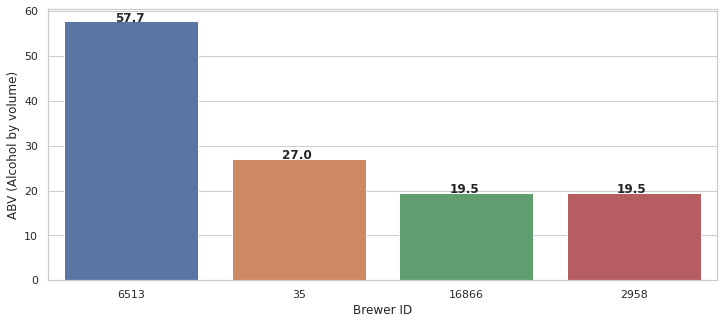

In [38]:
#ABV - Alcohol by volume (https://en.wikipedia.org/wiki/Alcohol_by_volume)

#The strength of beer is measured by its alcohol content by volume expressed as a percentage,
#that is to say, the number of millilitres of absolute alcohol (ethanol) in 100 mL of beer.(https://en.wikipedia.org/wiki/Beer_measurement)

top3 = beer_data.sort_values('beer_ABV',ascending=False).drop_duplicates('beer_brewerId').nlargest(4,'beer_ABV')
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='beer_brewerId',y='beer_ABV', data=top3,order=top3['beer_brewerId'])
ax.set(xlabel='Brewer ID', ylabel='ABV (Alcohol by volume)')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()),fontweight ='bold')
plt.show()

##### Answer -  Brewer 6513, 35, 16866, and 2958 produce the strongest beers.

##### Question: Which year did beers enjoy the highest ratings? 

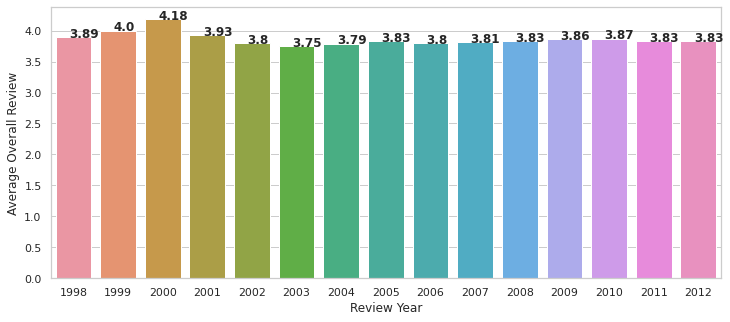

In [39]:
#Use review_overall columns to get the average review for the beer.

year_rating = pd.DataFrame(beer_data.groupby('review_year')['review_overall'].mean()).rename(columns={'review_overall':'Average_Overall_Review'})
year_rating['Average_Overall_Review'] = year_rating['Average_Overall_Review'].apply(lambda x: round(x,2))
year_rating = year_rating.reset_index()

plt.figure(figsize=(12, 5))
ax=sns.barplot(x='review_year',y='Average_Overall_Review', data=year_rating)
ax.set(xlabel='Review Year', ylabel='Average Overall Review')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()),fontweight ='bold')
plt.show()

- We observe in 2000 there is highest rating but year 2000 only have 33 reviews so we can't infer rating from that.
- And for year 2012 there is only one month rating so not consider this also.
- From year 2002 to 2011, year 2010 has the highest average overall review.



##### Answer -  In Year 2010 beers enjoy the highest ratings.

##### Question: Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

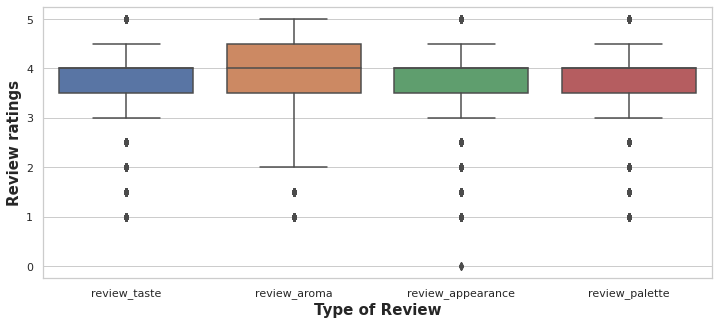

,review_taste,review_aroma,review_appearance,review_palette
count,528544.000000,528544.000000,528544.000000,528544.000000
mean,3.765993,3.817339,3.864519,3.758956
std,0.668987,0.718854,0.603987,0.685287
min,1.000000,1.000000,0.000000,1.000000
25%,3.500000,3.500000,3.500000,3.500000
50%,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.500000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [40]:
#Create a review dataframe which conatins columns as 'review_taste','review_aroma','review_appearance','review_palette'.
reviews = beer_data[['review_taste','review_aroma','review_appearance','review_palette']]
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(reviews))
plt.xlabel('Type of Review',fontsize = 15,fontweight ='bold')
plt.ylabel('Review ratings',fontsize = 15,fontweight ='bold')
plt.show()

reviews.describe()

##### Answer - The distribution of the "aroma" review is wide amongst all, so we can infer that aroma is one of the most important factors.

##### Question: If you were to recommend 3 beers to your friends based on this data which ones will you recommend?


In [41]:
#Create that dataframe that keeps a record of 10 beer name as per the highest review count and have the mean of review_overall of that beer.
avg_review = pd.DataFrame(beer_data.groupby('beer_name')['review_overall'].mean()).rename(columns={'review_overall':'Average Review'})
count_review = pd.DataFrame(beer_data.groupby('beer_name')['review_overall'].count()).rename(columns={'review_overall':'Review Count'})
top10_avgreview = pd.concat([avg_review,count_review],axis=1)
top10_avgreview = top10_avgreview.sort_values(['Review Count'],ascending=[False]).head(10).reset_index()

#From the above dataframe sort 3 beer name who is having the best/highest overall review
top3beer =  top10_avgreview.sort_values(by=['Average Review'],ascending=False).head(3)
top3beer['Average Review'] = round(top3beer['Average Review'],2)

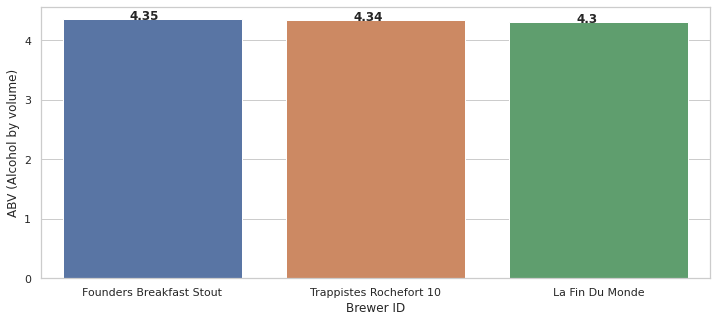

,beer_name,Average Review,Review Count
2,Founders Breakfast Stout,4.35,2500
8,Trappistes Rochefort 10,4.34,2169
4,La Fin Du Monde,4.30,2479


In [42]:
#PLot top 3 beer which is haveing est average review
plt.figure(figsize=(12, 5))
ax=sns.barplot(x='beer_name',y='Average Review', data=top3beer)
ax.set(xlabel='Brewer ID', ylabel='ABV (Alcohol by volume)')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()),fontweight ='bold')
plt.show()

top3beer

##### Answer- I will recommend Founders Breakfast Stout, Trappistes Rochefort 10, and La Fin Du Monde beer to my friends based on the review count and average overall rating of the beer. 

##### Question: Which Beer style seems to be the favorite based on reviews written by users? 

In [43]:
#Create a dataframe having top 10 beer style as per the review count
top10beer_style_review_text = pd.DataFrame(beer_data.groupby('beer_style')['review_text'].count().sort_values(ascending=False).head(10))
top10beer_style_review_text = top10beer_style_review_text.reset_index()

#list of top10 beer style
style=list(top10beer_style_review_text['beer_style'])

#create a dataframe with records that contains only beer_style which is present in top10beer_style_review_text
review_type = beer_data[beer_data['beer_style'].isin(style)]

#review_type.head()

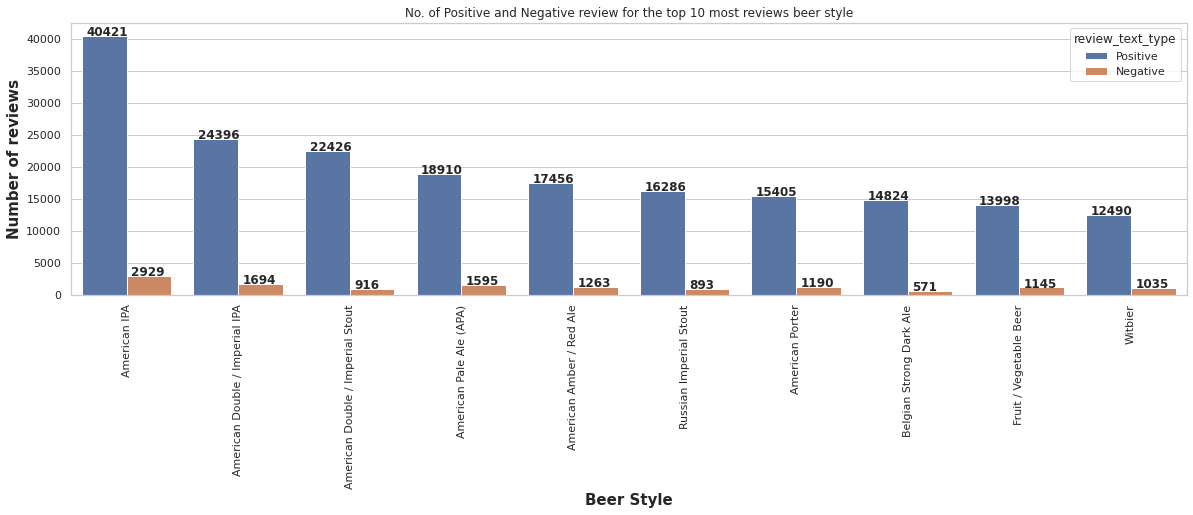

****************************************************************************************************


beer_style                        review_text_type
American Amber / Red Ale          Positive            93.252845
                                  Negative             6.747155
American Double / Imperial IPA    Positive            93.507091
                                  Negative             6.492909
American Double / Imperial Stout  Positive            96.075743
                                  Negative             3.924257
American IPA                      Positive            93.243368
                                  Negative             6.756632
American Pale Ale (APA)           Positive            92.221409
                                  Negative             7.778591
American Porter                   Positive            92.829165
                                  Negative             7.170835
Belgian Strong Dark Ale           Positive            96.291004
                                  Negative             3.708996
Fruit / Vegetable Beer            Positive           

In [44]:
#Plot top 10 beer style which is having highest review.
plt.figure(figsize=(20,5))
ax=sns.countplot(x=review_type['beer_style'],hue=review_type['review_text_type'],order=review_type['beer_style'].value_counts().index)
plt.xlabel('Beer Style',fontweight ='bold',fontsize = 15)
plt.ylabel('Number of reviews',fontweight ='bold',fontsize = 15)
plt.title('No. of Positive and Negative review for the top 10 most reviews beer style')
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()),fontweight ='bold')
plt.xticks(rotation=90)       
plt.show()

print("*" * 100)
review_type.groupby('beer_style')['review_text_type'].value_counts(normalize=True) * 100

##### Answer- As per the review count for the top 10 beer stye, Belgian Strong Dark Ale having the higest Positive review ~ 96.30 %, so its seems to be favorite beer style.

##### Question: How does written review compare to overall review score for the beer styles?

In [45]:
pd.DataFrame(review_type.groupby('beer_style')['review_overall'].mean())

,review_overall
beer_style,
American Amber / Red Ale,3.857818
American Double / Imperial IPA,3.951073
American Double / Imperial Stout,4.100356
American IPA,3.989619
American Pale Ale (APA),3.869812
American Porter,3.872733
Belgian Strong Dark Ale,4.009321
Fruit / Vegetable Beer,3.559301
Russian Imperial Stout,4.025729


##### Answer- As per the Positive and Negative review, we can observe that the beer style(top10 as per reivews count) who is having a high Positive rate  ( Belgian Strong Dark Ale ~ 96.3%, American Double / Imperial Stout ~ 96.1%, Russian Imperial Stout ~94.8%) also having the mean high overall review.
